In [ ]:
!pip install --no-deps simplejson
!pip install --no-deps citylearn==1.8.0
# !pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 26.2 MB/s eta 0:00:00


In [ ]:
# system files
import sys, os

# type hinting
from typing import List, Mapping

# Data visualization
import time
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

# custom modules
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'
sys.path.append(os.path.join(cwd))
from preprocessing import set_schema_buildings, set_schema_simulation_period, set_active_observations, get_timestep
from plot_kpi import plot_simulation_summary, plot_actions, plot_rewards
from mpc import MPC

%matplotlib inline

# Suppress DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

root_directory = schema['root_directory']

In [ ]:
# edit next code line to change number of buildings in simulation
BUILDING_INDEX = [7]

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['month',
                       'day_type',
                       'hour',
                       'diffuse_solar_irradiance',
                       'diffuse_solar_irradiance_predicted_6h',
                       'diffuse_solar_irradiance_predicted_12h',
                       'direct_solar_irradiance',
                       'direct_solar_irradiance_predicted_6h',
                       'direct_solar_irradiance_predicted_12h',
                       'carbon_intensity',
                       'non_shiftable_load',
                       'solar_generation',
                       'electrical_storage_soc',
                       ]

schema, buildings = set_schema_buildings(schema, BUILDING_INDEX)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print('Selected buildings:', buildings)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_7']
Active observations: ['month', 'day_type', 'hour', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc']


In [ ]:
# set pricing obervation to shared
# デフォルトだと、電力料金は住宅ごとで分かれているため、ひとつにまとめる
pricing_obs = ['electricity_pricing',
               'electricity_pricing_predicted_6h',
               'electricity_pricing_predicted_12h',
               'electricity_pricing_predicted_24h']

for ob in pricing_obs:
    schema["observations"][ob]['shared_in_central_agent']=True

In [ ]:
# １つのAgentですべての住宅を制御
schema['central_agent'] = True

In [ ]:
analysis_schema = schema.copy()

# Testing timestep
START = get_timestep(6,17,0)
STOP = get_timestep(6,23,23)

# START = get_timestep(6,5,0)
# STOP = get_timestep(6,8,23)

analysis_schema = set_schema_simulation_period(analysis_schema,
                                               START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (7680, 7847)


# Analysis

In [ ]:
mpc_env = CityLearnEnv(analysis_schema)

In [ ]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []
states_list = []

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    hist = mpc_de.optimize(generations=2500)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/actions3.txt"), np.array(actions_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/observations3.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/states3.txt"), np.array(states_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/history3.txt"), np.array(hist_list), delimiter=",")

In [ ]:
[plt.plot(hist_list[i]) for i in range(len(hist_list))];

# rerun

In [ ]:
mpc_env = CityLearnEnv(analysis_schema)

In [ ]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

In [ ]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []
states_list = []

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    hist = mpc_de.optimize(generations=2500)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/actions1_2.txt"), np.array(actions_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/observations1_2.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/states1_2.txt"), np.array(states_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/history1_2.txt"), np.array(hist_list), delimiter=",")

In [ ]:
[plt.plot(hist_list[i]) for i in range(len(hist_list))];

# RBC comparison

In [ ]:
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import colormaps
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

# type hinting
from typing import List, Mapping
from ipywidgets import IntProgress, VBox, HTML

# CityLearn
from citylearn.agents.rbc import HourRBC

In [ ]:
rbc_env = CityLearnEnv(analysis_schema)

In [ ]:
class CustomRBC(HourRBC):
   def __init__(
       self, env: CityLearnEnv, action_map: Mapping[int, float] = None,
       loader: IntProgress = None
    ):
      r"""Initialize CustomRBC.

      Parameters
      ----------
      env: Mapping[str, CityLearnEnv]
         CityLearn environment instance.
      action_map: Mapping[int, float]
         Mapping of hour to control action.
      loader: IntProgress
         Progress bar.
      """

      super().__init__(env=env, action_map=action_map)
      self.loader = loader

   def next_time_step(self):
      r"""Advance to next `time_step`."""

      super().next_time_step()

      if self.loader is not None:
         self.loader.value += 1
      else:
         pass

In [ ]:
action_map = {}
for i in range(1,25):
    if i >= 6 and i <=14:
        action_map[i] = 0.11
    else:
        action_map[i] = -0.067
rbc_model = CustomRBC(env=rbc_env, action_map=action_map)

In [ ]:
sac_episodes = 1
rbc_model.learn(episodes=sac_episodes)

Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


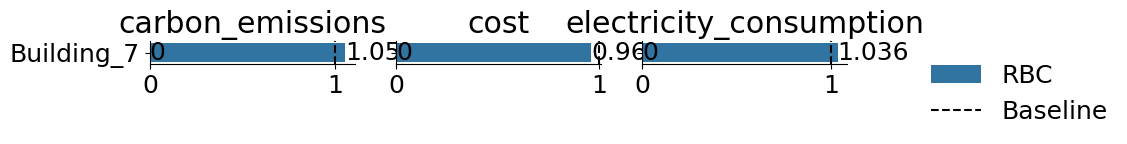

Building-level load profiles:


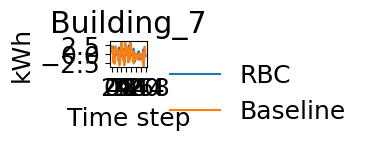

Battery SoC profiles:


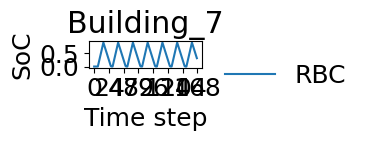

District-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:169: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


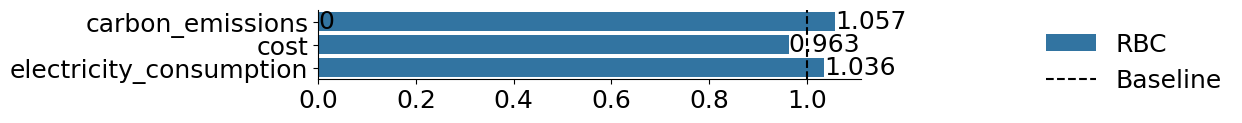

District-level load profiles:


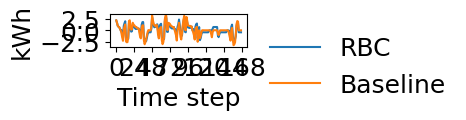

In [ ]:
plot_simulation_summary(
    {'RBC': rbc_env}
)

In [ ]:
actions = np.loadtxt(os.path.join(cwd,"month_analysis","actions3.txt"),delimiter=",")

In [ ]:
mpc_env = CityLearnEnv(analysis_schema)

In [ ]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


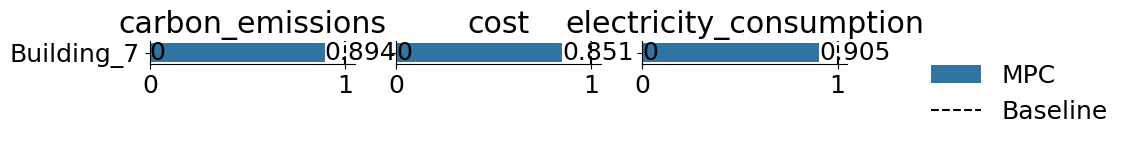

Building-level load profiles:


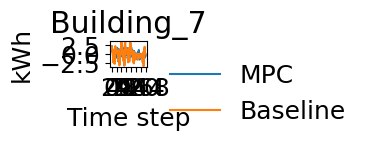

Battery SoC profiles:


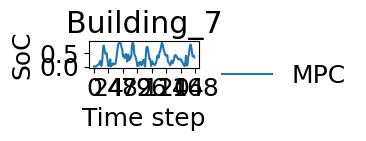

District-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:169: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


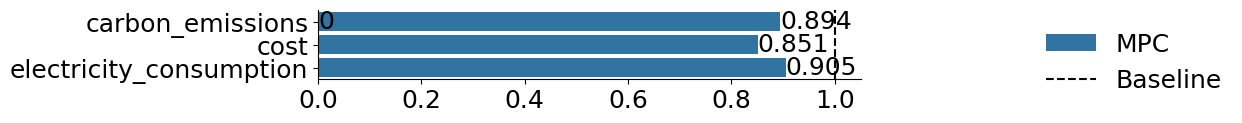

District-level load profiles:


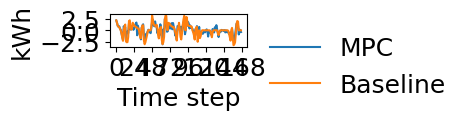

In [ ]:
observations = mpc_env.reset()
i = 0

while not mpc_env.done:
    observations_list.append(observations)
    # _ = mpc_de.optimize(generations=2500)
    # actions = mpc_de.predict_mpc()
    observations, _, _, _ = mpc_env.step([[actions[i]]])
    mpc_de.update_mpc()
    i += 1

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [62]:
import math
def plot_battery_soc_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 5
    row_count = min(column_count_limit, building_count)
    column_count = math.ceil(building_count/column_count_limit)
    figsize = (16,5)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize,sharey=True)


    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            soc = np.array(v.buildings[i].electrical_storage.soc)
            capacity = v.buildings[i].electrical_storage.capacity_history[0]
            y = soc/capacity
            x = range(len(y))
            ax.plot(x, y, label=k)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            ax.set_ylim(-0.02, 1.02)

        # ax.set_title(f"Home {bldg_idx[i]}")
        # ax.set_xlabel('Time step')
        # ax.set_ylabel(f"SoC/n[-]")
        # fig.text(0.04,0.5, "State of Charge [$kWh/kWh_{Capacity}$]", ha="center", va="center", rotation=90)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax.set_xticklabels(['     Fri','     Sat','     Sun','     Mon','     Tue','     Wed','     Thu','     Fri',' '], ha='left')
        ax.set_xlabel("Testing Period (hr)")

        if i == building_count - 1:
            ax.legend(
                ncol=1,
                loc='center right',
                bbox_to_anchor=(1.15, 0.8)
            )
        else:
            ax.legend().set_visible(False)

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel("State of Charge [$kWh/kWh_{Capacity}$]", labelpad=25)
    plt.subplots_adjust(hspace=0.5)
    # plt.tight_layout()

    return fig

<ipython-input-62-a5cbbf670db0>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['     Fri','     Sat','     Sun','     Mon','     Tue','     Wed','     Thu','     Fri',' '], ha='left')


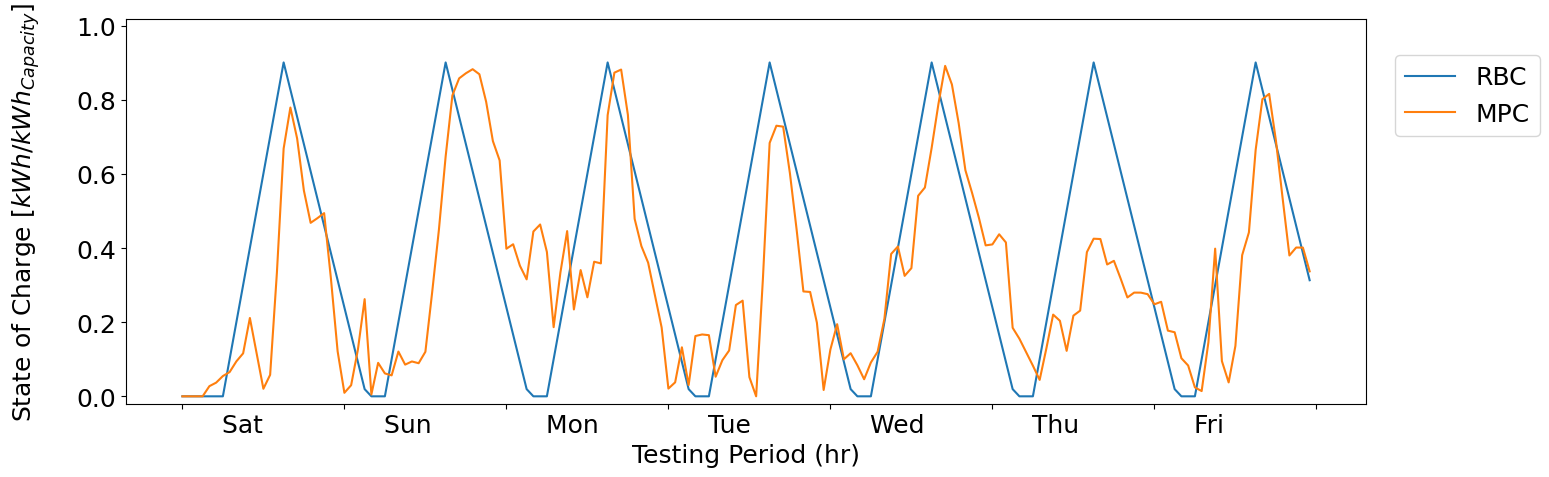

In [63]:
plt.rcParams["font.size"] = 18

fig = plot_battery_soc_profiles(
    {
        'RBC':rbc_env,
        'MPC':mpc_env
    }
)
# plt.savefig("soc.png", dpi=600, format="png", bbox_inches='tight')
plt.savefig("soc.svg", dpi=300, format="svg", bbox_inches='tight')